## Neuron

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#### McCulloch-Pitts neuron
As an example, we will use Tensors to implement the McCulloch-Pitts neuron for a simple logical function. The McCulloch-Pitts neuron operates on boolean inputs, and uses a threshold activation to produce a boolean output. The function can be written as

$$
f(\mathbf{x}) = 
\begin{cases}
1 \quad \text{if } \sum_i x_i \ge b\\
0 \quad \text{if } \sum_i x_i < b
\end{cases}
$$

what is does is it, takes inputs $x_i$ and sums them, if that sum is greater than or equal to a threshold value , b then it returns 1 else it returns 0


In [2]:
def logical_and(x):
    #takes a single binary input vector x and returns 1 if all the elements are 1 and 0 otherwise 
    return tf.cast(tf.math.greater_equal(tf.reduce_sum(x), tf.reduce_prod(tf.shape(x))), tf.int32)

#### The perceptron
The perceptron is also a linear binary classifier, but with more flexible weights. It can be written as the following function

$$
f(\mathbf{x}) = 
\begin{cases}
1 \quad \text{if } \sum_i w_i x_i + b \ge 0\\
0 \quad \text{if } \sum_i w_i x_i + b < 0
\end{cases}
$$

so, just like before if the weighted sum of inputs $(w_j. x_j)$ plus a bias, b is greater or equal to zero, then its equal to 1 and 0 otherwise.

In [3]:
# Define the perceptron classifier
def perceptron(x):
    return tf.math.greater_equal(tf.tensordot(x, weights, axes=1) + bias, 0.) # leaving this output as a bolean 

#remember that matrix multiplication is the same as the sum of the products, ie (1,2,3)@(3,2,1).T = 1.3 + 2.2 + 3.1 

In [4]:
#random data points

data = tf.random.normal((100,2)) # rank 2 tensor with 100 rows and 2 columns

# Use variables for the weights and bias (so we can update there values) 
# Use tensors for the inputs (which remain constant)

weights = tf.Variable(tf.constant([1., 0.5]), name='Weights')

bias = tf.Variable(tf.constant([-0.5]), name='Bias')


Summary: I have created 100 2-d pts. We apply our perceptron, which sums each pt in our data with the weight we specify and adds the bias. If that sum is greater than zero, then the associated pt is in class 1. Else (its negative) its in class 0

In [5]:
def perceptron_plot(preds):
    positive_class = data[preds] # All the Trues
    negative_class = data[~preds] # ~ is NOT ie NOT True = False (Tilda)

    plt.scatter(positive_class[:, 0], positive_class[:, 1], alpha=0.5, label='Positive')
    plt.scatter(negative_class[:, 0], negative_class[:, 1], alpha=0.5, label='Negative')
    plt.title('Perceptron Classifications')
    plt.legend()
    plt.show()

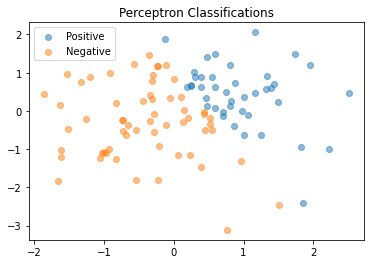

In [6]:
#plot the pts coloured by class predicition#

#preds are boolian (True/False) based on perceptron classifer
preds = perceptron(data)


#plot these classifications
perceptron_plot(preds)

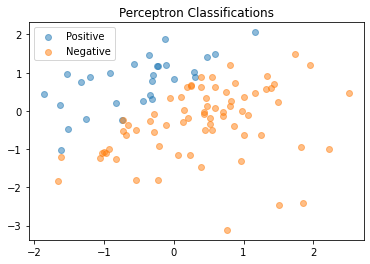

In [7]:
#if I use different values for the weights and bias, then we'll get a different decision boundary.

# Update the weights and bias and re-plot
weights.assign_sub([1.2, 0.3]) # subtacting from original weight
bias.assign_add([0.4]) #adding to orginal bias

preds = perceptron(data)
#plot these classifications
perceptron_plot(preds)

## Creating My Own (low-level) Layer - Subclassing Layer Class

The `Dense` class inherits from the base [`Layer` class](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer), which is core to the high level Keras API in TensorFlow. `Layer` objects encapsulate a state (the layer parameters) and the computation that is carried out by the layer. 

An example implementation of an affine transformation layer is shown below as a subclass of `Layer`.

In [8]:
#define a Affine Transformation Layer - which subclasses from super class, Layer!

from tensorflow.keras.layers import Layer 

#inheriting from Layer 
class Affine(Layer):
    
    #define constructor s.t we run constructor from super class (Layer) and create our weight, bias and a counter variable
    def __init__(self, units, input_dim, name='affine_1'):
        super(Affine, self).__init__(name=name)
        
        self.counter = tf.Variable(0, name='counter', dtype=tf.int32, trainable=False)
        
        #initalise our weight with shortcut fun!
        w_init = tf.random_normal_initializer()
        #weights must have shape (input_dim, units) s.t the operation x.w can be computed. x.shape=(batch_dim, input_dim)!
        self.w = tf.Variable(initial_value=w_init(shape=(input_dim, units), dtype='float32'), name='kernal', trainable=True)
        
        #bias
        b_init = tf.zeros_initializer()
        #bias must have shape (units,) since x.w produces shape (batch_dims, units). thus final axes has to align!
        self.b = tf.Variable(initial_value=b_init(shape=(units,), dtype='float32'), 
                             trainable=True, name='bias')
        
        
    def call(self, inputs):
        # the computation that this layer works out is called in the call method.
        # NOTE: inputs already has the batch dim included i.e inputs.shape=(batch_dim, input_shape)
        # KEY NOTE: input_shape-whole shape. input_dim=input_shape[-1] its the number of dims! i.e. inputs=(1,2,3)
        # give batch_dim=1, input_shape=(2,3) and input_dims=3
        
        #calculate the affine transformation
        self.counter.assign_add(1) #increment counter
        return tf.matmul(inputs, self.w) + self.b

In [9]:
# Create an INSTANCE of the Affine layer class
affine = Affine(units=3, input_dim=2)

#show all the variables in our affine layer
affine.weights

[<tf.Variable 'kernal:0' shape=(2, 3) dtype=float32, numpy=
 array([[-3.4054305e-02, -6.7597292e-02,  9.0504058e-02],
        [-2.9514626e-02,  2.4642589e-02,  1.7732485e-06]], dtype=float32)>,
 <tf.Variable 'bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'counter:0' shape=() dtype=int32, numpy=0>]

In [10]:
# CALL the affine layer on an input

affine(inputs=tf.ones([1, 2])) #batch dim=1 length=2 i.e this vector is (1,1)

#our weights will have shape (input_dim, units)=(2,3)
#therefore our output will have shape (batch_dim, input_dim)(input_dim, units)=(batch_dim, units)
#as expected the output is a (1,3) tensor - 1 for the batch size and 3 for the number of neurons in our data

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.06356893, -0.04295471,  0.09050583]], dtype=float32)>

#### Build Method 

Note that for our `Affine` layer class we need to supply both input and output dimensions, but for the `Dense` layer class the input dimension is inferred when the layer is first called. 

we can change this by creating the build method
It is good practice to defer creation of the weights using the `build` method:

In [11]:
# Create an Affine layer class that defers creation of the weights 

class NewAffine(Layer):
    
    def __init__(self, units, name='affine'): #no longer have input dimension
        #call superclass initialiser
        super(NewAffine, self).__init__(name=name)
        #create class variable 'units'- to store the number of neurons
        self.units = units
        
    def build(self, input_shape): # This build method will only be called once the layer needs to be built
        
        # add_weight is a method in the Layer (superclass) which adds/creates a new variable
        # we extract the input dim from the input shape (size of the last dim)
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal') 
        self.b = self.add_weight(shape=(self.units,), initializer='zeros')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [12]:
# Create an INSTANCE of the Affine layer class

new_affine = NewAffine(units=3)

In [13]:
# CALL the affine layer on an input

new_affine(inputs=tf.ones([1,2]))

#again output shape=(batch_dim, units) as expected

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.01377805, -0.08132357, -0.13263357]], dtype=float32)>

In [14]:
# Inspect the weights
new_affine.weights

#as expected weights.shape=(input_dims, units)

[<tf.Variable 'affine/Variable:0' shape=(2, 3) dtype=float32, numpy=
 array([[ 0.0363901 , -0.0100138 , -0.06302095],
        [-0.02261206, -0.07130978, -0.06961261]], dtype=float32)>,
 <tf.Variable 'affine/Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

#### Now creating a very simple MLP using My (low-Level) Affine Layer 

In [15]:
from tensorflow.keras.models import Sequential

#just two Affine Layers with three neurons
model = Sequential([
    NewAffine(units=3, name='aff_1'),
    NewAffine(units=3, name='aff_2'),
    
])

In [16]:
# Call the model on an input to create the weights

x = tf.random.normal((2, 6)) # rank 2 tensor - batch_dim=2 and length of each batch is rank-1 tensor of length 6
y = model(x)

In [17]:
# Inspect the model parameters
model.weights

[<tf.Variable 'aff_1/Variable:0' shape=(6, 3) dtype=float32, numpy=
 array([[ 0.12045969, -0.04524912, -0.07895038],
        [ 0.01315376,  0.04786119, -0.03313734],
        [ 0.053732  ,  0.02817422,  0.03171282],
        [ 0.0142214 , -0.05856531, -0.04454268],
        [-0.0466736 , -0.03383939,  0.04506366],
        [-0.06021134,  0.04555295, -0.04732353]], dtype=float32)>,
 <tf.Variable 'aff_1/Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'aff_2/Variable:0' shape=(3, 3) dtype=float32, numpy=
 array([[ 0.10590549, -0.03225996,  0.03352259],
        [ 0.00628021,  0.02640208, -0.04844187],
        [ 0.07966795,  0.07323718, -0.04244522]], dtype=float32)>,
 <tf.Variable 'aff_2/Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
aff_1 (NewAffine)            (2, 3)                    21        
_________________________________________________________________
aff_2 (NewAffine)            (2, 3)                    12        
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [19]:
#we can access first layer kernal(weight matrix)
model.layers[1].w

<tf.Variable 'aff_2/Variable:0' shape=(3, 3) dtype=float32, numpy=
array([[ 0.10590549, -0.03225996,  0.03352259],
       [ 0.00628021,  0.02640208, -0.04844187],
       [ 0.07966795,  0.07323718, -0.04244522]], dtype=float32)>

# MLP - MNIST Dataset

In [20]:
# Load the MNIST dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

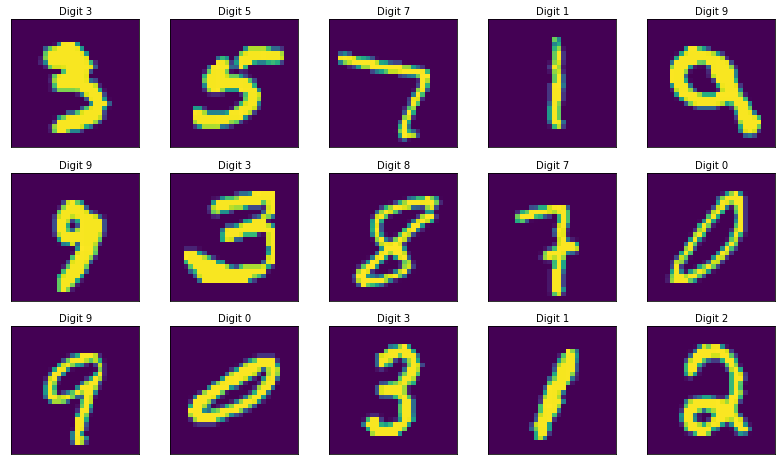

In [21]:
#View some examples in the dataset

n_rows, n_cols = 3, 5
random_inx = np.random.choice(x_train.shape[0], n_rows * n_cols, replace=False)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

for n, i in enumerate(random_inx):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(x_train[i])
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].text(10., -1.5, f'Digit {y_train[i]}')
plt.show()

In [24]:
# Create an MNIST classifier model

# input images have dim 28x28. Dense layers requires inputs to be 1 dim array. 
# Flatten unrolls into 1 dim array of length 784 (28x28)
from tensorflow.keras.layers import Flatten, Dense

mnist_model = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(10, activation='softmax') # last layer needs 10 neurons, 1 for each digit and use soft max (multi-classification)
])

mnist_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [25]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

As our labels `y_train` and `y_test` are in sparse form (ie just the interger - whereas categorical_crossentropy would expect an array with a one in the place of the interger that it has been classsed as, known as a one-hot format), we use the `sparse_categorical_crossentropy` loss function. We also will use the stochastic gradient descent (SGD) optimiser.

* If your true labels, Yi's, are **one-hot encoded**, use **categorical_crossentropy**. Examples (for a 3-class classification): [1,0,0] , [0,1,0], [0,0,1]

* But if your true label's, Yi's, are **integers**, use **sparse_categorical_crossentropy**. Examples for above 3-class classification problem: [1] , [2], [3]

In [26]:
#compile it - optimizer and loss fun

mnist_model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [27]:
#The image data is filled with integer pixel values from 0 to 255. 
#To facilitate the training, we RESCALE the values to the interval [0, 1].

# Rescale the image data

x_train = x_train/255
x_test = x_test/255

In [28]:
#fit model - i.e. conduct training

#Its history.history attribute is a record of training loss values and metrics values at successive epochs.
#ONE epoch is one FULL run through the training data! (we divide our training data into batches of size 64
#after each batch model parameters are updated-i.e. In the backwards pass we sum up the per example grad of
#losses therefore in this case the sum would be over 64!)


history = mnist_model.fit(x_train, y_train, epochs=10, batch_size=64) 

Epoch 1/10
938/938 [==============================] - 1s 2ms/step - loss: 0.8553 - accuracy: 0.7854
Epoch 2/10
938/938 [==============================] - 1s 1ms/step - loss: 0.4154 - accuracy: 0.8889
Epoch 3/10
938/938 [==============================] - 1s 1ms/step - loss: 0.3434 - accuracy: 0.9043
Epoch 4/10
938/938 [==============================] - 1s 1ms/step - loss: 0.3084 - accuracy: 0.9123
Epoch 5/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2849 - accuracy: 0.9187
Epoch 6/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2668 - accuracy: 0.9235
Epoch 7/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2518 - accuracy: 0.9275
Epoch 8/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2385 - accuracy: 0.9312
Epoch 9/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2267 - accuracy: 0.9350
Epoch 10/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2156 - accuracy: 0.9380

In [29]:
# Evaluate the model on the test set

mnist_model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 2ms/step - loss: 0.2118 - accuracy: 0.9394


[0.21181152760982513, 0.9394000172615051]

In [30]:
# Get predictions from model

preds = mnist_model.predict(x_test)
preds.shape


(10000, 10)

In [33]:
preds[0]

array([1.5529037e-04, 9.5696223e-06, 1.1050346e-03, 4.1550552e-03,
       1.2312905e-05, 3.0174981e-05, 3.3539604e-07, 9.9353254e-01,
       1.2517146e-04, 8.7442488e-04], dtype=float32)

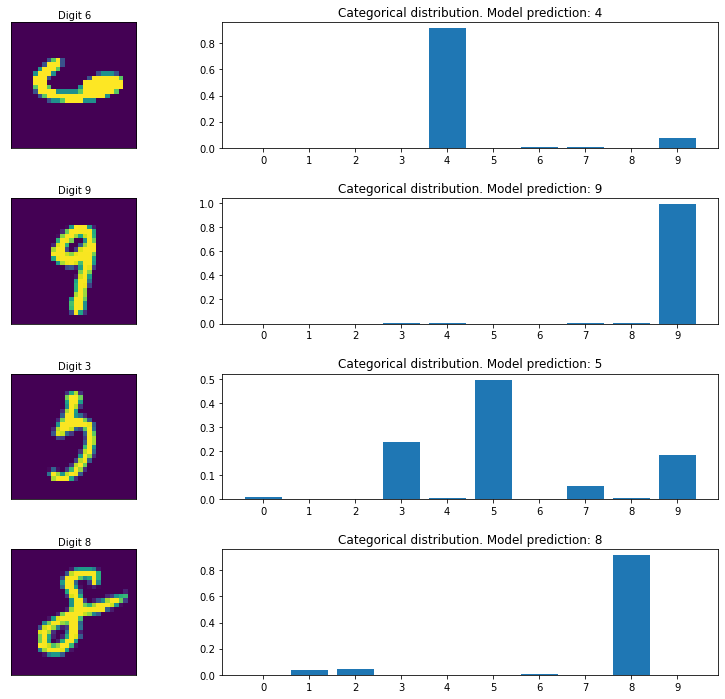

In [31]:
# Plot some predicted categorical distributions

# gets probabilites for 4 randomly selected images from the test set and it 
# is going to display these images along with the predictive distribution of the model
# and the correct label

num_test_images = x_test.shape[0]

random_inx = np.random.choice(num_test_images, 4)
random_preds = preds[random_inx, ...]
random_test_images = x_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(random_preds, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
plt.show()